<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/practice/ViT_For_Binary_Classification_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Vision Transformer for Binary Classification of Custom Dataset with PyTorch

In [ ]:
!pip install linformer
!pip install vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [78]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import torch.utils.data as data
import torchvision
from torchvision.transforms import ToTensor
from torchvision import transforms
torch.cuda.is_available()

True

In [73]:
train_directory = r'/content/drive/MyDrive/image_dataset_splited/train'
val_directory = r'/content/drive/MyDrive/image_dataset_splited/val'
test_directory = r'/content/drive/MyDrive/image_dataset_splited/test'

# Hyperparameters:
batch_size = 16
epochs = 30
lr = 2e-6
gamma = 0.5
seed = 142
IMG_SIZE = 224
patch_size = 8
num_classes = 2

In [74]:
# 데이터 증강 및 전처리를 위한 변환 정의
transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [75]:
# Tensor Transforms (with Augmentation) and Pytorch Preprocessing:
train_ds = torchvision.datasets.ImageFolder(train_directory, transform=transform_augment)
valid_ds = torchvision.datasets.ImageFolder(val_directory, transform=transform_augment)
test_ds = torchvision.datasets.ImageFolder(test_directory, transform=transform_augment)

In [79]:
# Data Loaders:
train_loader = data.DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
valid_loader = data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [80]:
# Training device:
device = 'cuda'

# Linear Transformer:
efficient_transformer = Linformer(dim=128, seq_len=784+1, depth=12, heads=8, k=64)

# Vision Transformer Model:
model = ViT(dim=128, image_size=224, patch_size=patch_size, num_classes=num_classes, transformer=efficient_transformer, channels=3).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

# Learning Rate Scheduler for Optimizer:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [81]:
# Training:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0

        for data, label in valid_loader:

            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 5299 has 14.74 GiB memory in use. Of the allocated memory 13.62 GiB is allocated by PyTorch, and 1007.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [50]:
# Save Model:
PATH = "epochs"+"_"+str(epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
torch.save(model.state_dict(), PATH)

In [51]:
# load saved model:
PATH = "epochs"+"_"+str(epochs)+"_"+"img"+"_"+str(IMG_SIZE)+"_"+"patch"+"_"+str(patch_size)+"_"+"lr"+"_"+str(lr)+".pt"
efficient_transformer = Linformer(dim=128, seq_len=784+1, depth=12, heads=8, k=64)
model = ViT(image_size=224, patch_size=8, num_classes=2, dim=128 ,transformer=efficient_transformer, channels=3)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [52]:
# Performance on Valid/Test Data
def overall_accuracy(model, test_loader, criterion):

    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to('cpu'), data[1].to('cpu')
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1

    accuracy = correct/total

    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])

    return test_loss, accuracy, y_proba_out, y_truth_out


loss, acc, y_proba, y_truth = overall_accuracy(model, test_loader, criterion = nn.CrossEntropyLoss())


print(f"Accuracy: {acc}")

print(pd.value_counts(y_truth))

  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy: 0.475
1.0    20
0.0    20
dtype: int64


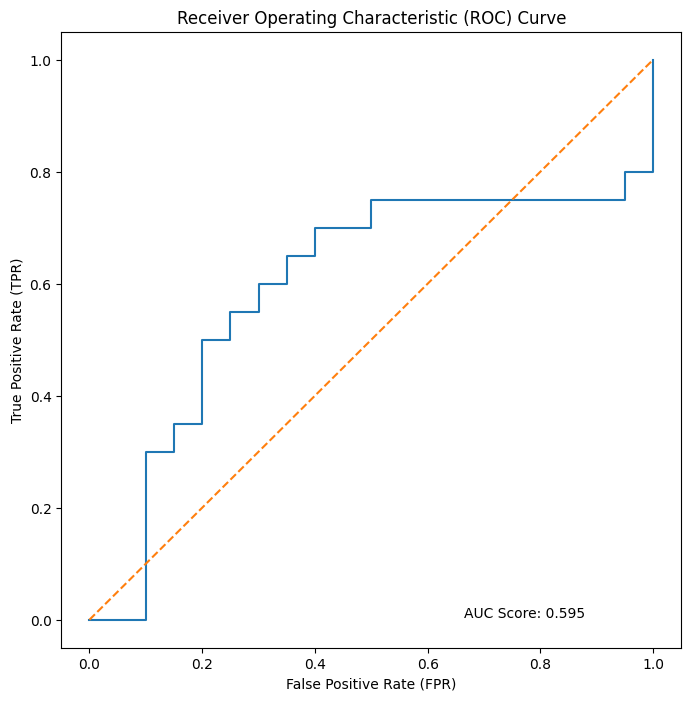

In [53]:
# Plot ROC curve:

def plot_ROCAUC_curve(y_truth, y_proba, fig_size):

    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.

    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure

    Returns: void
    '''

    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
#     plt.savefig('ROC.png')
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<Axes: >

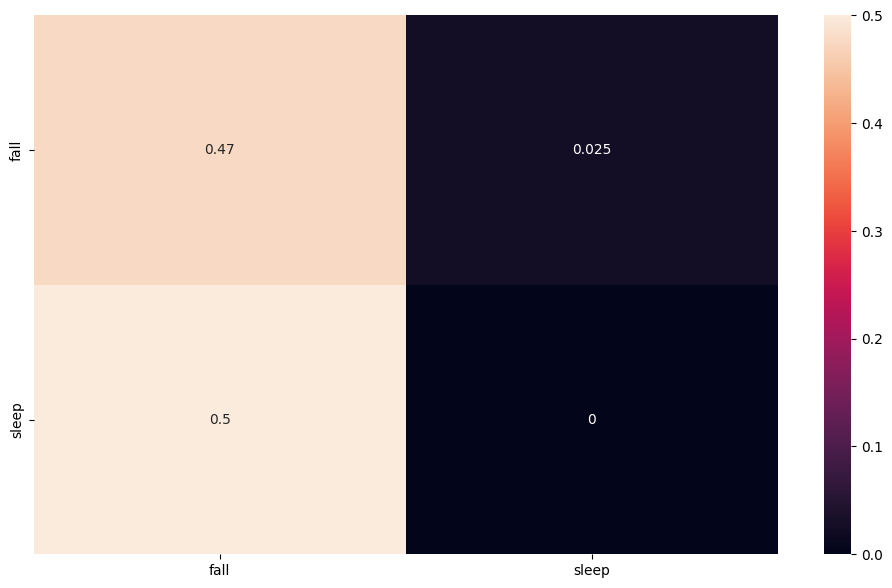

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

net = model
# iterate over test data
for inputs, labels in test_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('fall', 'sleep')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('cm.png')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


predicted fall tensor: tensor([[-0.3244, -0.3014]], grad_fn=<AddmmBackward0>)
predicted sleep tensor: tensor([[-0.4794, -0.1910]], grad_fn=<AddmmBackward0>)

smoke


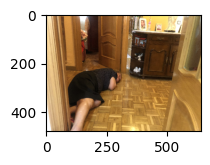

fall


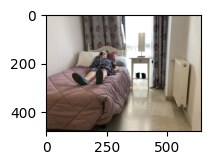

In [39]:
#Inference on Single Images (fall-sleep):
test_image = r"/content/drive/MyDrive/image_dataset_splited/test/Fall/Fall_003.jpg"
test_image_null = r"/content/drive/MyDrive/image_dataset_splited/test/Sleep/Sleep_003.jpg"
image = Image.open(test_image)
image_null = Image.open(test_image_null)

# Define tensor transform and apply it:
data_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
image_t = data_transform(image).unsqueeze(0)
image_null_t = data_transform(image_null).unsqueeze(0)

# Labels:
for inputs, labels in test_loader:
        labels = labels.data.cpu().numpy()

# Prediction:
out_fall = model(image_t)
out_sleep= model(image_null_t)
print("predicted fall tensor:", out_fall)
print("predicted sleep tensor:", out_sleep)
print("")
# Print:
if(labels[out_fall.argmax()]== 0):
    print("smoke")
else:
    print("else")

# Show Image:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()
# Print:
if(labels[out_sleep.argmax()]== 0):
    print("fall")
else:
    print("sleep")

# Show Image Null:
plt.figure(figsize=(2, 2))
plt.imshow(image_null)
plt.show()